In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from tqdm import trange
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import random, datetime, os, copy

# Gym is an OpenAI toolkit for RL
import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

gym.__version__

'0.26.0'

In [2]:
# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace
# Super Mario environment for OpenAI Gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT,COMPLEX_MOVEMENT 
# env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", render_mode='rgb_array', apply_api_compatibility=True)
env = JoypadSpace(env, SIMPLE_MOVEMENT)
n_actions = env.action_space.n
print("Action :",n_actions)

c:\Python3.10.4\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Python3.10.4\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


Action : 7


In [3]:
obs,info = env.reset()
obs.shape, info #3 dimension

((240, 256, 3), {})

### Test Gym is worked or not

In [4]:
# env.reset()
# done = True
# for step in range(500):
#     if done:
#         next_state = env.reset()
#     next_state, reward, done,_, info = env.step(env.action_space.sample())
#     env.render()
#     #img=env.render(mode="rgb_array")
    
# env.close()
# print('Done')

In [5]:
# obs,info = env.reset()
# obs.shape, info #3 dimension

In [6]:
import numpy as np
import random
from collections import deque
import torch
import math
import torch.nn as nn
import gym

def gen_epsilon_greedy_policy(epsilon):
    def policy_function(state, Q, available_actions):
        probs = torch.ones(len(available_actions)) * epsilon / len(available_actions)
        best_action = Q(state).squeeze()[available_actions].argmax().item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs,1).item()
        return available_actions[action]
    return policy_function

class Q_network(nn.Module):
    
    def __init__(self, n_action):
        super(Q_network, self).__init__()        
        self.layers = nn.Sequential(
            nn.Conv2d(4, 16, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.AvgPool2d((12,9)),
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_action)
        )
        
    def forward(self, x):
        return self.layers(x)


class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return torch.stack(state).squeeze(),  torch.tensor(action), torch.tensor(reward), torch.stack(next_state).squeeze(), torch.tensor(done).squeeze()
    
    def __len__(self):
        return len(self.buffer)

def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    def eps_by_episode(episode):
        return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

class Agent(object):

    def __init__(self, env, eps_by_episode):
        self.env = env
        self.n_actions = env.action_space.n
        self.eps_by_episode = eps_by_episode
        self.episodes = 0
        self.stack_size = 4
        self.skip_frames = 4
        self.restart_episode()

    def buffer(self,obs):
        obs = torch.tensor(obs).max(2).values / 255.0
        self.obs_buffer.append(obs)

    def restart_episode(self):
        obs, info = self.env.reset()
        self.policy = gen_epsilon_greedy_policy(self.eps_by_episode(self.episodes))
        self.obs_buffer = deque(maxlen=((self.stack_size-1)*self.skip_frames+1))
        self.buffer(obs.copy())
        self.episodes += 1

    def collect_state(self):
        frame_inds = [-1-n*self.skip_frames for n in range(self.stack_size)]
        frames = [self.obs_buffer[max(f,-len(self.obs_buffer))] for f in frame_inds]
        return torch.stack(frames)

    def act(self,Q):
        state = self.collect_state().unsqueeze(0)
        action = self.policy(state,Q,range(self.n_actions))
        obs, reward, terminated , truncated, info = self.env.step(action)
        self.buffer(obs.copy())
        new_state = self.collect_state().squeeze(0)
        if terminated or truncated:
            self.restart_episode()
        return state, action, reward, new_state, terminated or truncated

In [7]:
import torch
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
device

device(type='cpu')

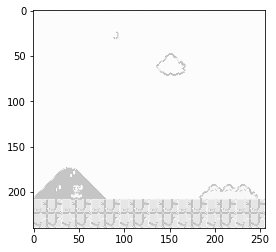

In [9]:
import matplotlib.pyplot as plt
import gym
import copy
from IPython import display
%matplotlib inline

bufsize = 100
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 1000
batch_size = 64
gamma = 0.99

Q = Q_network(n_actions).to(device)
Qhat = Q_network(n_actions).to(device)
D = ReplayBuffer(bufsize)
eps_by_episode = gen_eps_by_episode(epsilon_start,epsilon_final,epsilon_decay)
A = Agent(env, eps_by_episode)

loss_fn = nn.MSELoss()
optimzer = torch.optim.Adam(Q.parameters())

Q.train()
Qhat.eval()
step = 0
C = 1000
episode_rewards = 0
episodes_rewards = []

while True:
    state, aciton, reward, next_state, done = A.act(Q)
    print(next_state.shape)
    plt.imshow(torch.permute(next_state,(1,2,0)))
    display.display(plt.gcf())    
    display.clear_output(wait=True)
    episode_rewards += reward
    if done:
        print('Done :',done)
        episodes_rewards.append(episode_rewards)
        episode_rewards = 0
        display.clear_output(wait=True)
        plt.plot(episodes_rewards)
        display.display(plt.gcf())

    D.push(state, aciton, reward, next_state, done)
    if len(D) >= batch_size:
        states, acitons, rewards, next_states, dones = D.sample(batch_size)
        outputs = Q(states).gather(-1,acitons.unsqueeze(1)).squeeze()
        targets = rewards + gamma*Qhat(next_states).max(1).values.detach() * dones
        loss = loss_fn(outputs,targets)
        print('Loss %f' % loss)
        loss.backward()
        optimzer.step()
        if (step+1) % C == 0 :
            Qhat = copy.deepcopy(Q)
            Qhat.eval()
        step += 1
    break #delete it